In [2]:
import os
import pathlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [ ]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

In [ ]:
y_train=tf.keras.utils.to_categorical(y_train,num_classes=10)
y_test=tf.keras.utils.to_categorical(y_test,num_classes=10)


In [ ]:
def feature_extractor(inputs):
  feature_extract=tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),weights="imagenet")(inputs)
  return feature_extract
def classifier(features):
  inputs=tf.keras.layers.GlobalAveragePooling2D()(features)
  x=tf.keras.layers.Flatten()(inputs)
  x=tf.keras.layers.Dense(1024,activation='relu')(x)
  x=tf.keras.layers.Dense(512,activation='relu')(x)
  x=tf.keras.layers.Dense(10,activation='softmax')(x)
  return x 

In [ ]:
inputs=tf.keras.layers.Input(shape=(32,32,3))
resize=tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
features=feature_extractor(resize)
classification=classifier(features)
model=tf.keras.Model(inputs=inputs,outputs=classification)


In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               5248

In [ ]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])
model.fit(x_train,y_train,batch_size=32,epochs=20,verbose=1,validation_data=(x_test,y_test))

Epoch 1/20
1563/1563 [==============================] - 572s 364ms/step - loss: 0.6684 - acc: 0.7799 - val_loss: 0.2378 - val_acc: 0.9200
Epoch 2/20
  76/1563 [>.............................] - ETA: 8:28 - loss: 0.1534 - acc: 0.9558

KeyboardInterrupt: ignored

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2390, done.
remote: Counting objects: 100% (2390/2390), done.
remote: Compressing objects: 100% (1978/1978), done.
remote: Total 2390 (delta 564), reused 1497 (delta 385), pack-reused 0
Receiving objects: 100% (2390/2390), 30.74 MiB | 39.10 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py . 
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608062 sha256=0cdf83fbd70fffa678d176e0f2751e7672018402800aa3741344f2b3778b78a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-_a41g2ju/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=79d72c69484b8989d045241946c92e79b1b284c12d21a1e72b3d21fe70e67307
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=57eae5a2bc010faf1c12ae37e066635f6bbfa94a29a4ec95afeda73c17475c84
  Stored in directory: /root/



ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [ ]:
from object_detection.utils import label_map_util 
from object_detection.utils import visualization_utils as vis_utils
from object_detection.utils import ops as utils_ops

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [ ]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


In [ ]:
detector = hub.load(model_handle)

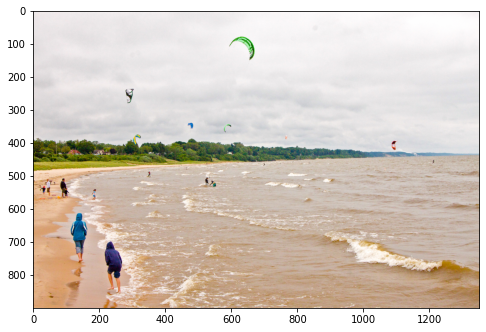

In [ ]:
selected_image = 'Beach' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False #@param {type:"boolean"}
convert_image_to_grayscale = False #@param {type:"boolean"}

image_path = IMAGES_FOR_TEST[selected_image]
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(8,6))
plt.imshow(image_np[0])


In [ ]:
result=detector(image_np)


In [ ]:
result={key:value.numpy() for key,value in result.items()}

In [ ]:
result['detection_classes']

array([[38.,  1.,  1., 38., 38., 38.,  1.,  1., 38.,  1.,  1., 38.,  1.,
         1.,  1., 38., 42., 42.,  1., 38., 42., 38.,  1.,  1.,  1., 31.,
        38., 38., 42.,  1., 31., 27.,  1.,  1., 38.,  1., 38., 38.,  1.,
        38., 37., 38., 38., 27., 38., 38., 38., 44., 38., 38., 27.,  1.,
         1., 38., 18.,  1., 38., 42., 16., 38.,  9.,  1.,  1., 27., 27.,
        38., 38.,  1., 38., 38.,  1.,  1., 38., 38., 31., 38.,  1., 38.,
        38., 31., 42.,  9., 38., 34., 40., 38., 38.,  1., 38., 38.,  1.,
         3., 18., 27., 38., 18.,  1., 31., 42., 38.]], dtype=float32)

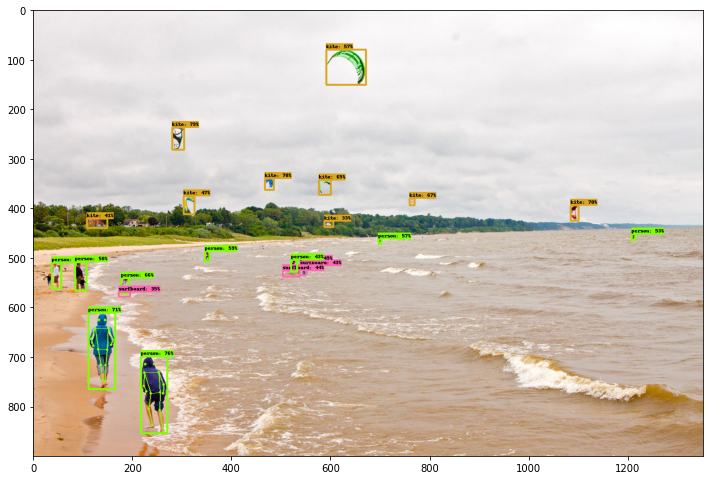

In [ ]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

vis_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(12,24))
plt.imshow(image_np_with_detections[0])


#Class activation Map

In [ ]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=x_train.reshape((-1,28,28,1))
x_test=x_test.reshape((-1,28,28,1))
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

4423680/4422102 [==============================] - 0s 0us/step


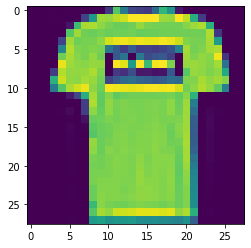

In [ ]:
plt.imshow(x_train[1].reshape((28,28)))

In [ ]:
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Conv2D(32,3,padding="same",activation="relu",input_shape=(28,28,1)),
                                  tf.keras.layers.MaxPooling2D((2,2)),
                                  tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
                                  tf.keras.layers.MaxPooling2D((2,2)),
                                  tf.keras.layers.Conv2D(128,3,padding="same",activation="relu"),
                                  tf.keras.layers.MaxPooling2D((2,2)),
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dense(10,activation="softmax")
                                  
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)              

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,shuffle=True,batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 13s 3ms/step - loss: 0.8517 - acc: 0.6921 - val_loss: 0.4487 - val_acc: 0.8387
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3987 - acc: 0.8584 - val_loss: 0.3663 - val_acc: 0.8717
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3401 - acc: 0.8776 - val_loss: 0.3560 - val_acc: 0.8748
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2948 - acc: 0.8927 - val_loss: 0.3127 - val_acc: 0.8906
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2592 - acc: 0.9059 - val_loss: 0.2864 - val_acc: 0.8950


In [ ]:
import scipy as sp 

In [ ]:
gap_weights=model.layers[-1].get_weights()[0]
cam_model=tf.keras.models.Model(inputs=model.input,outputs=[model.layers[-3].output,model.layers[-1].output])
cam_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)         0   

In [ ]:
features,results=cam_model.predict(x_test)
features.shape

(10000, 3, 3, 128)

In [ ]:
def show_cam(i):
  image_index=i
  feature_img=features[image_index,:,:,:]
  preds=np.argmax(results[image_index])
  class_activaion_weights=gap_weights[:,preds]
  class_activation_features=sp.ndimage.zoom(feature_img,zoom=(28/3,28/3,1),order=2)
  cam_out=np.dot(class_activation_features,class_activaion_class)
  print("propability:",results[image_index][preds])
  plt.imshow(np.squeeze(x_test[image_index]-1),alpha=0.5)
  if results[image_index][preds]>=0.95:
    cmap_str="Greens"
  
  else:
    cmap_str="Reds"
  plt.imshow(cam_out,cmap=cmap_str,alpha=0.5)
  plt.show()

propability: 0.9780466


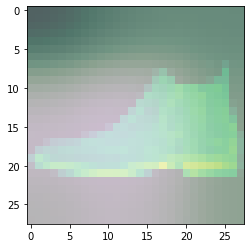

propability: 0.99957377


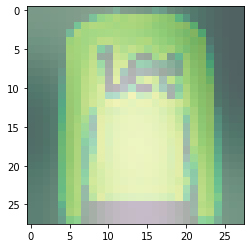

propability: 0.9999964


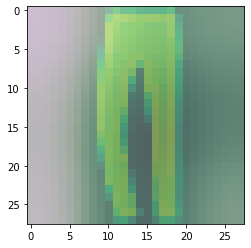

propability: 0.99999666


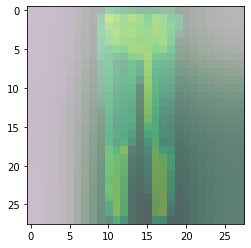

propability: 0.8256054


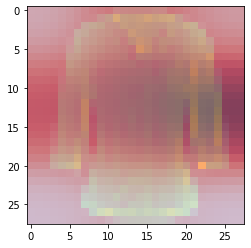

propability: 0.99994576


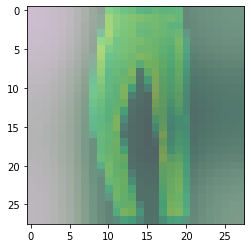

propability: 0.6099526


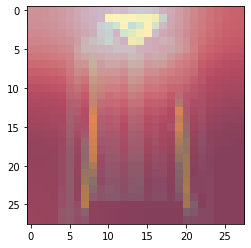

propability: 0.9705321


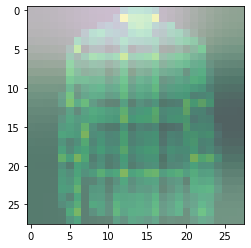

propability: 0.9864021


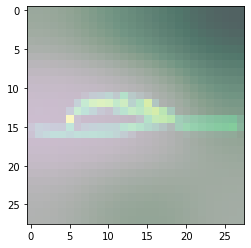

propability: 0.99988174


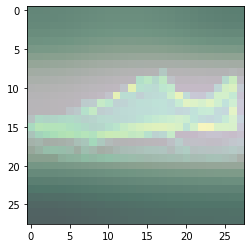

propability: 0.9169864


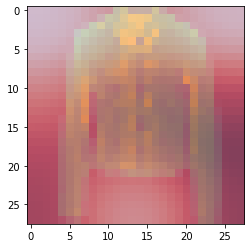

propability: 0.9852604


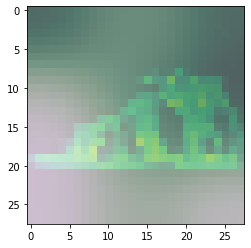

propability: 0.5429346


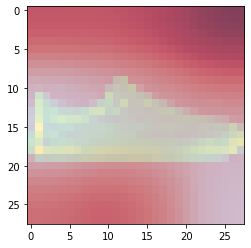

propability: 0.999864


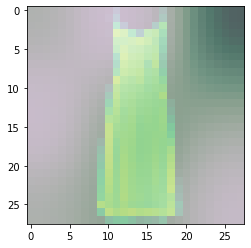

propability: 0.8889533


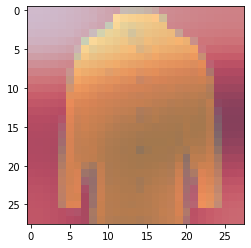

propability: 0.99882346


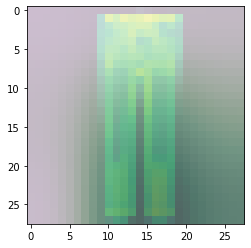

propability: 0.7694203


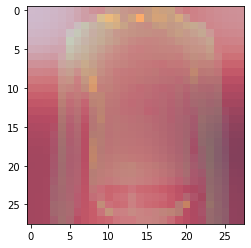

propability: 0.7207328


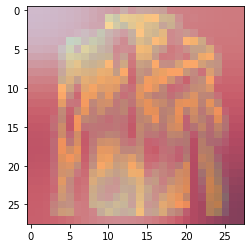

propability: 0.9976763


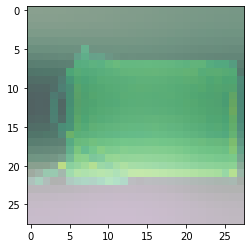

propability: 0.94702625


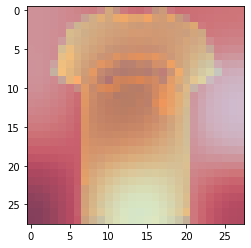

propability: 0.9630064


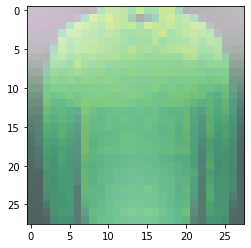

propability: 0.5303542


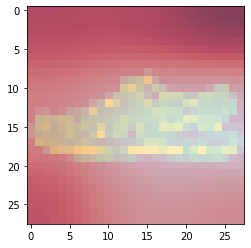

propability: 0.9993693


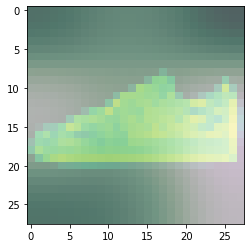

propability: 0.9653588


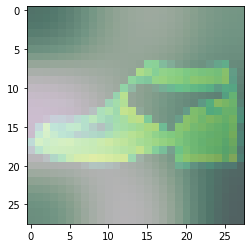

propability: 0.99999654


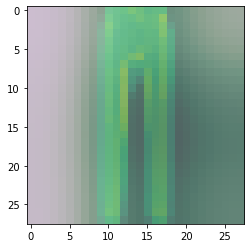

propability: 0.48966163


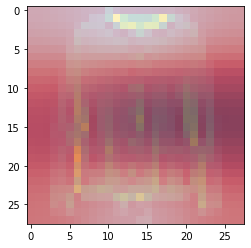

propability: 0.9472055


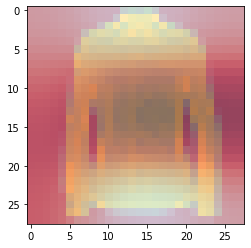

propability: 0.47216472


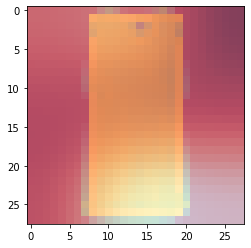

propability: 0.9932127


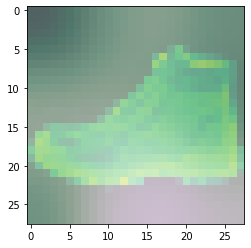

propability: 0.4875893


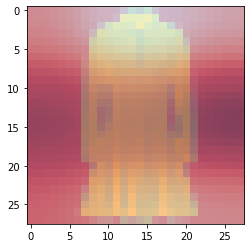

propability: 0.9999969


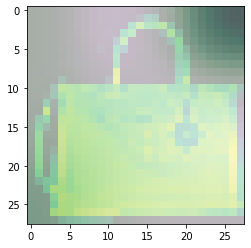

propability: 0.9910307


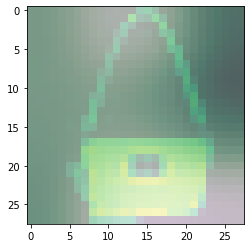

propability: 0.9684335


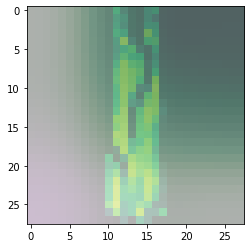

propability: 0.98579204


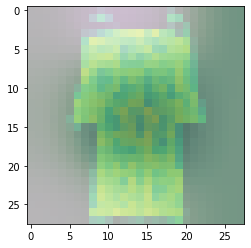

propability: 0.9940456


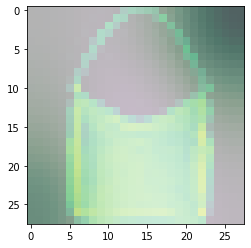

propability: 0.90819055


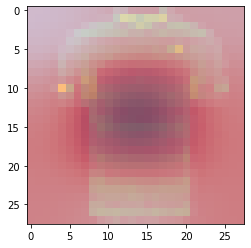

propability: 0.99995255


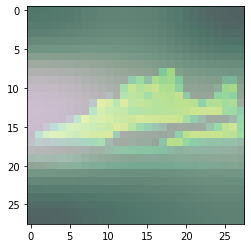

propability: 0.96941537


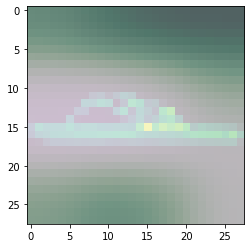

propability: 0.9993414


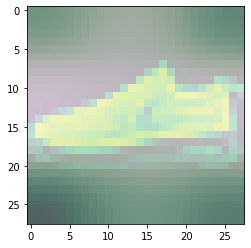

propability: 0.99984753


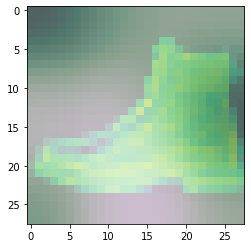

propability: 0.6928807


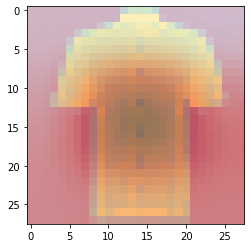

propability: 0.99990654


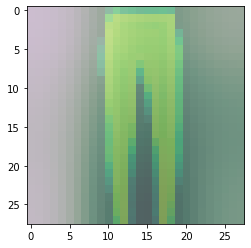

propability: 0.449612


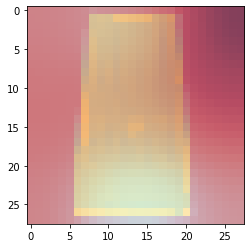

propability: 0.8098996


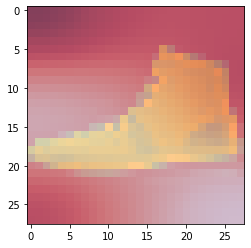

propability: 0.9313225


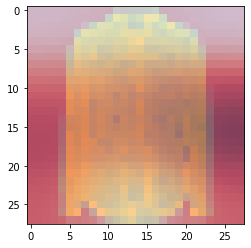

propability: 0.723732


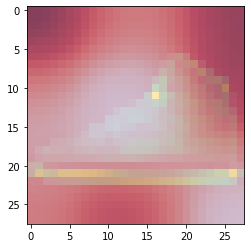

propability: 0.61655176


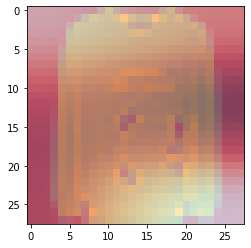

propability: 0.9916019


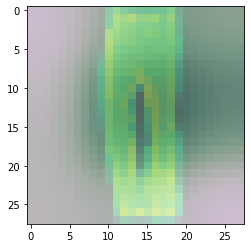

propability: 0.4304476


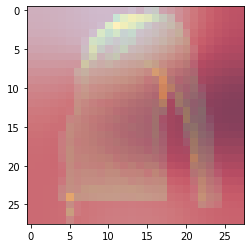

propability: 0.84288865


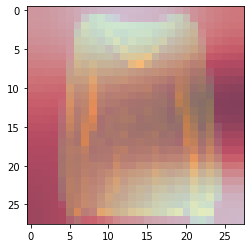

propability: 0.68607897


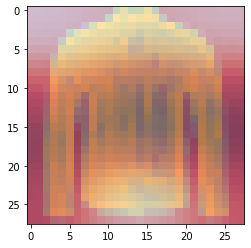

propability: 0.5708442


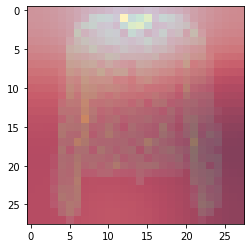

propability: 0.99945575


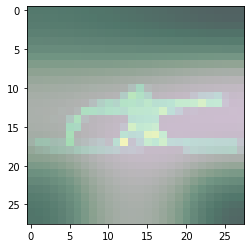

propability: 0.7563226


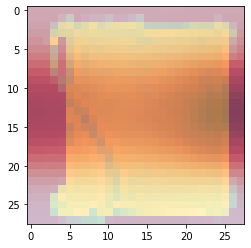

propability: 0.9482143


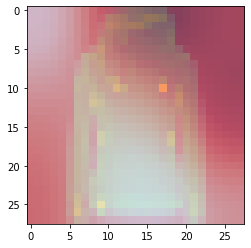

propability: 0.9467847


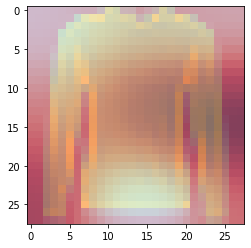

propability: 0.9997482


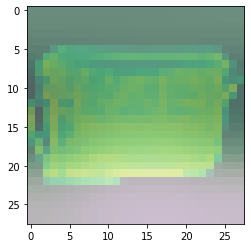

propability: 0.595073


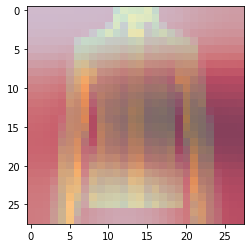

propability: 0.9985619


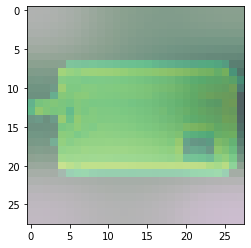

propability: 0.9814601


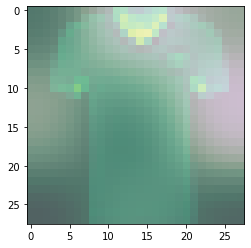

propability: 0.99909914


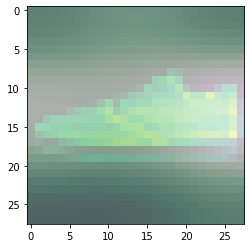

propability: 0.9605547


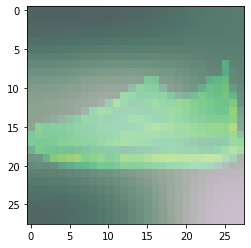

propability: 0.996424


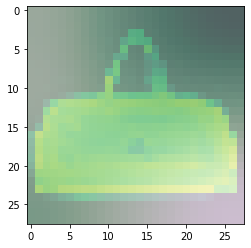

propability: 0.99783486


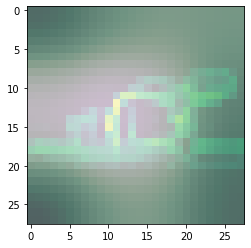

propability: 0.99999976


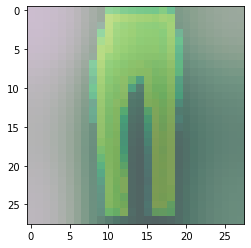

propability: 0.9964127


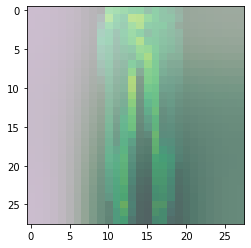

propability: 0.29901212


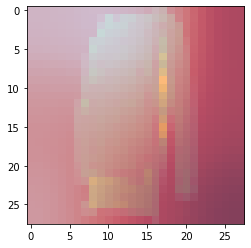

propability: 0.6690989


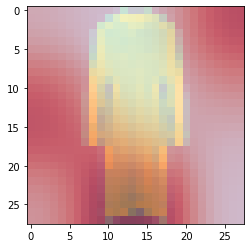

propability: 0.83758986


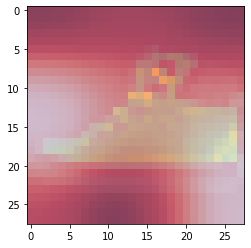

propability: 0.99999297


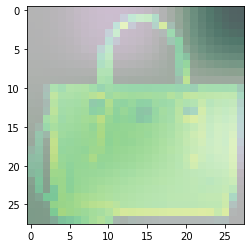

propability: 0.9992015


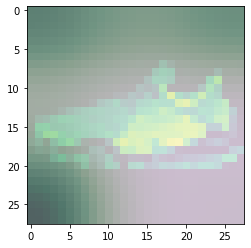

propability: 0.9288427


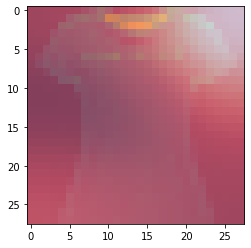

propability: 0.9665403


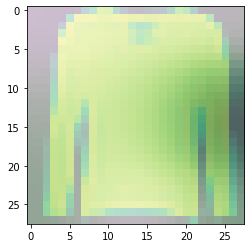

propability: 0.84608555


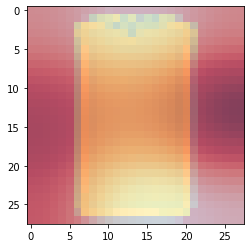

propability: 0.81899434


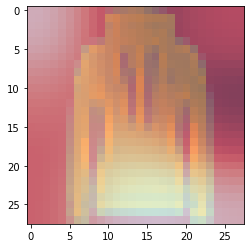

propability: 0.92692643


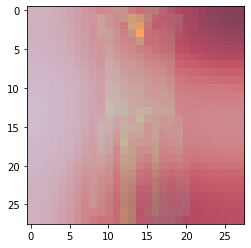

propability: 0.9999993


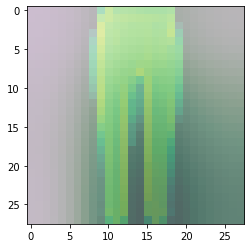

propability: 0.9990632


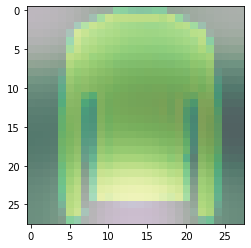

propability: 0.9996494


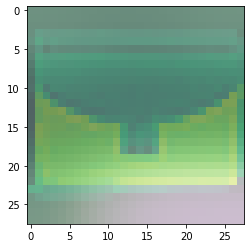

propability: 0.90015805


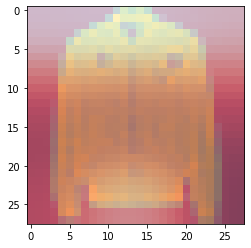

propability: 0.9988165


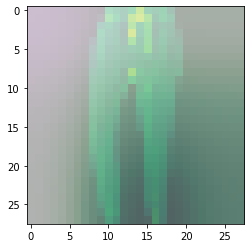

propability: 0.99445796


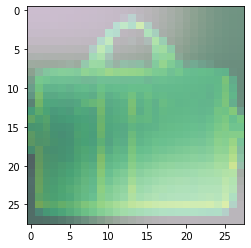

propability: 0.9999914


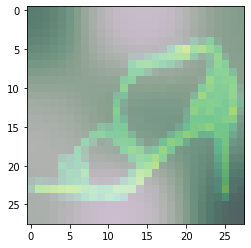

propability: 0.9999969


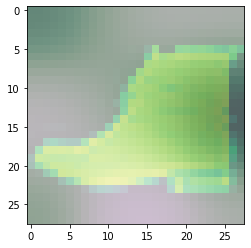

propability: 0.99984074


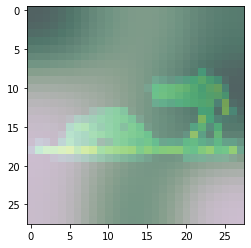

propability: 0.96765435


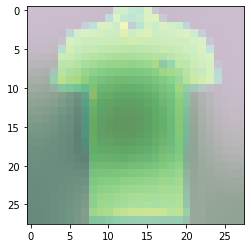

propability: 0.97064364


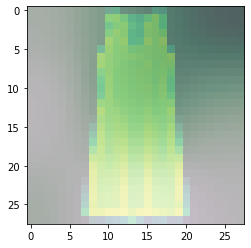

propability: 0.99917525


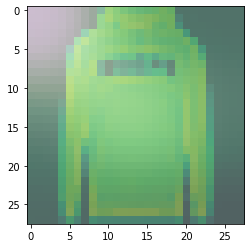

propability: 0.9975967


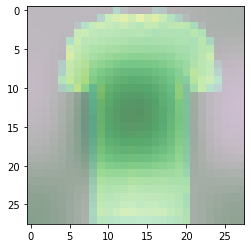

propability: 0.6504428


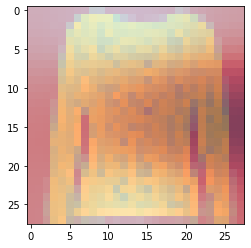

propability: 0.9994727


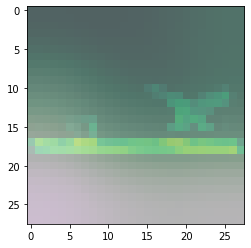

propability: 0.9758689


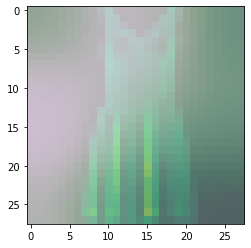

propability: 0.99577975


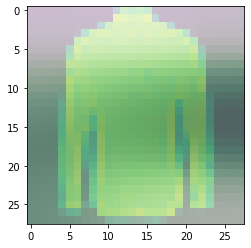

propability: 0.999376


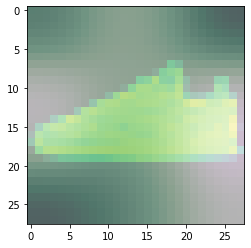

propability: 0.9999925


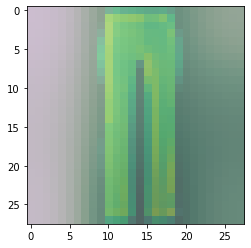

propability: 0.98750603


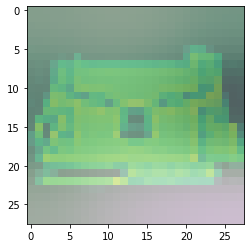

propability: 0.82907647


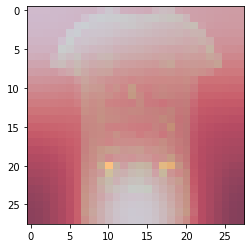

propability: 0.9992508


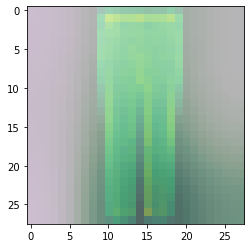

propability: 0.8599383


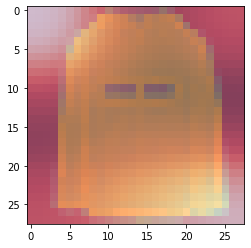

propability: 0.99202687


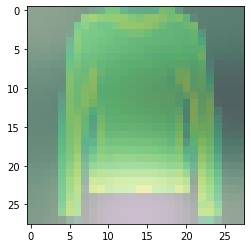

In [ ]:
for i in range(0,100):
  show_cam(i)

#Siliancy

In [6]:
model=tf.keras.models.Sequential([
              hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'),
              tf.keras.layers.Activation('softmax')                    
])
model.build([None,300,300,3])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              23853833  
_________________________________________________________________
activation_1 (Activation)    (None, 1001)              0         
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


In [7]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2021-01-13 09:11:28--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165993 (162K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 162.10K  --.-KB/s    in 0.02s   

2021-01-13 09:11:28 (10.2 MB/s) - ‘image.jpg’ saved [165993/165993]



In [8]:
import cv2 

In [46]:
img = cv2.imread('image.jpg')

# format it to be in the RGB colorspace
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

# resize to 300x300 and normalize pixel values to be in the range [0, 1]
img = cv2.resize(img, (300, 300)) / 255.0

# add a batch dimension in front
image = np.expand_dims(img, axis=0)

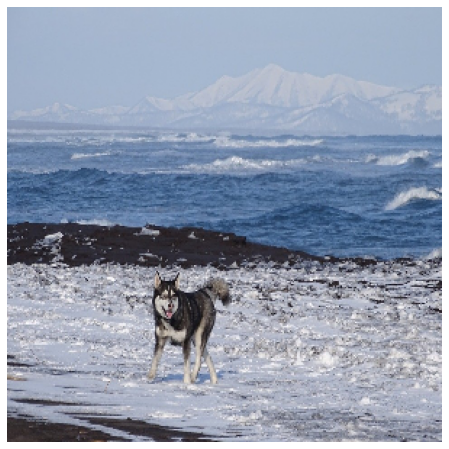

In [47]:
plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(img))
plt.axis('off')
plt.show()

In [79]:
class_index = 251   

# If you downloaded the cat, use this line instead
#class_index = 282   # Tabby Cat in ImageNet

# number of classes in the model's training data
num_classes = 1001

# convert to one hot representation to match our softmax activation in the model definition
expected_output = tf.one_hot([class_index] * image.shape[0], num_classes)
with tf.GradientTape() as tape:
  inputs=tf.cast(image,dtype=tf.float32)
  tape.watch(inputs)
  pred=model(inputs)
  loss=tf.keras.losses.categorical_crossentropy(expected_output,pred)
grads=tape.gradient(loss,inputs)

In [80]:
print(grads)

tf.Tensor(
[[[[ 2.16751662e-03 -3.19683226e-03 -1.30242168e-03]
   [-9.93509078e-04 -1.26817403e-03  2.18468765e-03]
   [ 4.53691557e-03  9.56877414e-03  1.13484953e-02]
   ...
   [-7.06991472e-04  7.39508600e-04 -5.30220277e-04]
   [-2.41709244e-03  7.63990683e-04  1.81844470e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 3.00034881e-03 -1.12953119e-03  2.25235079e-03]
   [ 6.99966075e-03  1.14915799e-02  7.66855478e-03]
   [ 1.14853848e-02  1.52690457e-02  1.61889736e-02]
   ...
   [ 3.18566523e-03 -4.71763499e-03 -2.58850749e-03]
   [ 3.45581211e-03 -6.33270596e-04  3.64369655e-04]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 2.45629321e-03  4.67261579e-03  4.73279925e-03]
   [ 3.61058908e-03  2.41479222e-02  1.80366486e-02]
   [ 3.53260525e-03  1.43404845e-02  1.23664560e-02]
   ...
   [ 5.85663598e-03 -1.18745957e-02 -8.58294312e-03]
   [ 4.61790245e-03 -8.70866515e-03 -2.29051616e-03]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  ...

 

In [81]:
gray_grads=tf.reduce_sum(tf.abs(grads),axis=-1)
normalized_grads=tf.cast(255*(gray_grads-tf.reduce_min(gray_grads)/(tf.reduce_max(gray_grads) - tf.reduce_min(gray_grads))),tf.uint8)

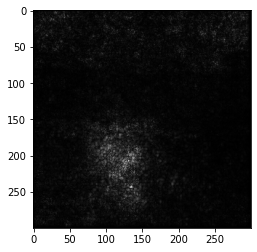

In [82]:
plt.imshow(np.squeeze(normalized_grads.numpy()),cmap='gray')

In [83]:
normalized_grads=tf.squeeze(normalized_grads)
color_map=cv2.applyColorMap(normalized_grads.numpy(),cv2.COLORMAP_HOT)
color_map=color_map/255.0
weighted=cv2.addWeighted(img,0.5,color_map,0.5,0.0)

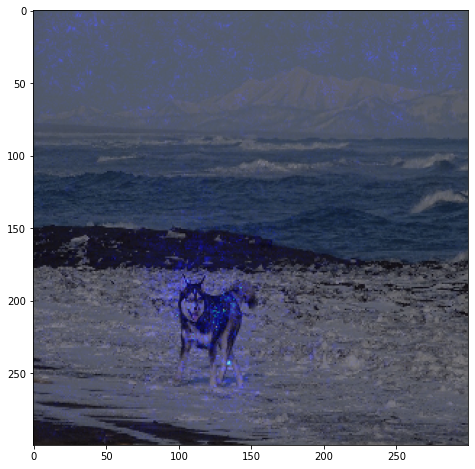

In [84]:
plt.figure(figsize=(8,8))
plt.imshow(weighted)

In [85]:
normalized_grads=normalized_grads.numpy()
normalized_grads

array([[ 1,  1,  6, ...,  0,  1,  0],
       [ 1,  6, 10, ...,  2,  1,  0],
       [ 3, 11,  7, ...,  6,  3,  0],
       ...,
       [ 0,  1,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [130]:
_,thresh=cv2.threshold(normalized_grads,75,255,cv2.THRESH_BINARY)
thresh

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

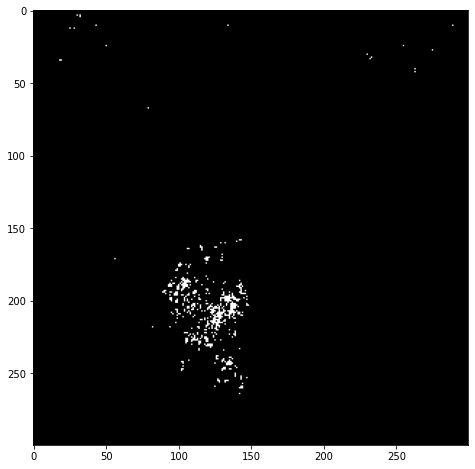

In [131]:
plt.figure(figsize=(8,8))
plt.imshow(thresh,cmap='gray')

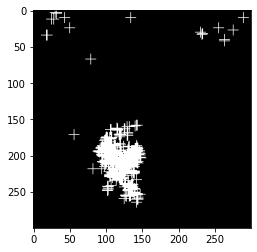

In [132]:
kernel_size_5_5 = (15,15)
kernel_dilate=cv2.getStructuringElement(cv2.MORPH_DILATE,kernel_size_5_5)
dilation=cv2.dilate(thresh,kernel_dilate,iterations=1)
plt.imshow(dilation,cmap='gray')

In [133]:
countours,hierichy=cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

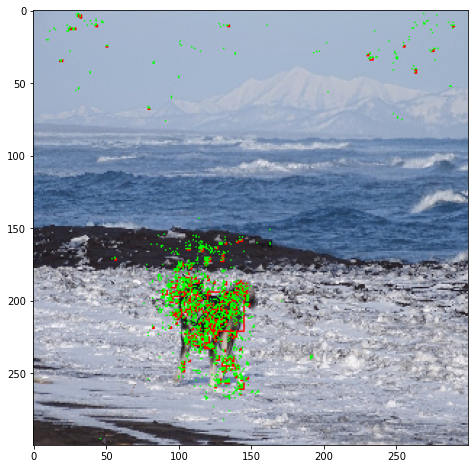

In [134]:
for cnt in countours:
  if cnt.all()>200:
    cnt=cnt.reshape((-1,1,2))
  rect=cv2.polylines(img,[cnt],True,(0,255,0))
plt.figure(figsize=(8,8))
plt.imshow(rect)